In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5
    print(distance)

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

def get_gaussian_kernel2(k=3, mu=0, sigma=1, normalize=True): # looped version to make kernel
    g_2D = np.zeros((k,k))
    kc = (k-1)/2
    for i in range(g_2D.shape[0]):
        for j in range(g_2D.shape[1]):
            temp = np.exp(-((i-kc-mu)**2 + (j-kc-mu)**2)/(2*sigma**2))
            gaussian_val = temp/(2 * np.pi * sigma ** 2)
            g_2D[i][j] = gaussian_val
    if normalize:
        g_2D = g_2D/np.sum(g_2D)
    return g_2D

In [ ]:
def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

In [ ]:
def get_thin_kernels(start=0, end=360, step=45):
        k_thin = 3  # actual size of the directional kernel
        # increase for a while to avoid interpolation when rotating
        k_increased = k_thin + 2

        # get 0° angle directional kernel
        thin_kernel_0 = np.zeros((k_increased, k_increased))
        thin_kernel_0[k_increased // 2, k_increased // 2] = 1
        thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

        # rotate the 0° angle directional kernel to get the other ones
        thin_kernels = []
        for angle in range(start, end, step):
            (h, w) = thin_kernel_0.shape
            # get the center to not rotate around the (0, 0) coord point
            center = (w // 2, h // 2)
            # apply rotation
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

            # get the k=3 kerne
            kernel_angle = kernel_angle_increased[1:-1, 1:-1]
            is_diag = (abs(kernel_angle) == 1)      # because of the interpolation
            kernel_angle = kernel_angle * is_diag   # because of the interpolation
            thin_kernels.append(kernel_angle)
        return thin_kernels

In [70]:
# canny edge detection more robust to noise than simple sobel filter
# implementation of kernel functions

class CNN(nn.Module):
    def __init__(self, rectangle_width, sharpness, k_gaussian=3, k_sobel=3, mu=0, sigma=1):
        super(CNN, self).__init__()
        #choosing device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # move tensors to device using  .to(device)

        # gaussian

        gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma)
        self.gaussian_pass = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_gaussian, padding=k_gaussian//2, bias=False)
        self.gaussian_pass.weight[:] = torch.from_numpy(gaussian_2D)

        # sobel x and y

        sobel_2D = get_sobel_kernel(k_sobel, mu, sigma)
        self.sobel_pass_x = nn.Conv2d(in_channels=1, out_channels=1, kernel_siz=k_sobel, padding=k_sobel//2, bias=False)
        self.sobel_pass_x.weight[:] = torch.from_numpy(sobel_2D)

        self.sobel_pass_y = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_sobel, padding=k_sobel//2, bias=False)
        self.sobel_pass_y.weight[:] = torch.from_numpy(sobel_2D.T)

        #thin

        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,out_channels=8, kernel_size=thin_kernels[0].shape, padding=thin_kernels[0].shape[-1] // 2, bias=False)
        self.directional_filter.weight[:, 0] = torch.from_numpy(directional_kernels)

         # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3, padding=1, bias=False)
        self.hysteresis.weight[:] = torch.from_numpy(hysteresis)

        def forward(self, x, low_threshold=None, high_threshold=None, hysteresis=False):
            B, C, H, W = x.shape # batch , channels, height, width (B, 1, 144, 256)
            blurred = torch.zeros((B, C, H, W)).to(self.device)
            grad_x = torch.zeros((B, 1, H, W)).to(self.device)
            grad_y = torch.zeros((B, 1, H, W)).to(self.device)
            grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
            grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)


            # gaussian
            blurred = self.gaussian_pass(x)

            #sobel
            grad_x = grad_x + self.sobel_pass_x(blurred)
            grad_y = grad_y + self.sobel_pass_y(blurred)

            # thick edges

            grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
            grad_orientation = torch.atan(grad_x/grad_y)
            grad_orientation = grad_orientation * (360/np.pi) + 180
            grad_orientation = torch.round(grad_orientation/45) * 45

            # thin edges

            directional = self.directional_filter(grad_magnitude)
            positive_idx = (grad_orientation/45) % 8
            negative_idx = ((grad_orientation/45)+4) % 8
            thin_edges = grad_magnitude.clone()
            # non-maximum supression by direction
            for pos_i in range(4):
                neg_i = pos_i +4
                is_oriented_i = (positive_idx == pos_i) * 1
                is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
                pos_directional = directional[:, pos_i]
                neg_directional = directional[:, neg_i]
                selected_direction = torch.stack([pos_directional, neg_directional])

                # get local maximum pixels for the angle
                is_max = selected_direction.min(dim=0)[0] > 0.0
                is_max = torch.unsqueeze(is_max, dim=1)

                # apply non-max suppression
                to_remove = (is_max ==0) * 1 * (is_oriented_i) > 0
                thin_edges[to_remove] = 0.0

                if low_threshold is not None:
                    low = thin_edges > low_threshold
                    if high_threshold is not None:
                        high = thin_edges > high_threshold
                        thin_edges = low * 0.5 + high * 0.5

                        if hysteresis:
                            weak = (thin_edges == 0.5) * 1
                            weak_is_high = (self.hysterisis(thin_edges) > 1) * weak
                            thin_edges = high * 1 + weak_is_high * 1
                    else:
                        thin_edges = low * 1

                return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges

                    





        


class pathDataset(Dataset): # dataloader
    def __init__(self, imgs_dir, transform):
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.all_imgs = os.listdir(imgs_dir)
    def __len__(self):
        return len(self.all_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imgs_dir, self.all_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

torch.Size([2, 1, 144, 256])


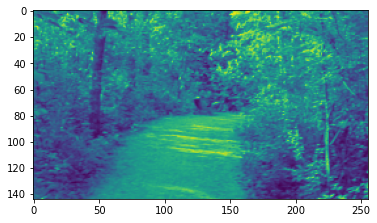

In [3]:
colorjitter = transforms.ColorJitter(.2, .3, .4, .5) # random values for now
grey = transforms.Grayscale(num_output_channels=1) # single channel image, 3 channel has r=g=b greyscale
tensor = transforms.ToTensor()
resize = transforms.Resize(size=[144, 256])
transfm = transforms.Compose([grey, colorjitter, resize, tensor])

dataset = pathDataset('practice_images', transform=transfm)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

for idx, images in enumerate(train_loader):
    print(images.shape)
    plt.imshow(images[0].permute(1, 2, 0))
    break

In [4]:
test_img = torch.rand(3, 144, 256)
test_batch = torch.rand(32, 3, 144, 256)